In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 3.9 MB/s 
     |████████████████████████████████| 197 kB 62.5 MB/s 
     |████████████████████████████████| 1.2 MB 66.7 MB/s 
     |████████████████████████████████| 60 kB 9.2 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [3]:
search_images_ddg

<function fastbook.search_images_ddg>

In [4]:
results = search_images_ddg('camel animal', max_images=100)
#ims = results.attrgot('contentUrl')
len(results), results[0]

(100,
 'https://2.bp.blogspot.com/-BYuKWQU-K80/T3G5qzpaagI/AAAAAAAAEIo/yV1vytmOKS0/s1600/camels+5.jpg')

In [ ]:
#hide
#ims = ['https://www.petz.com.br/blog/wp-content/uploads/2020/08/cat-sitter-felino-1280x720.jpg']

In [5]:
dest = 'images/camel.jpg'
download_url(results[0], dest)

Path('images/camel.jpg')

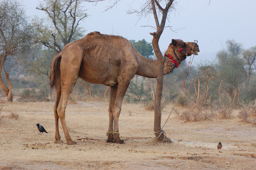

In [6]:
im = Image.open(dest)
im.thumbnail((256,256))
im

In [7]:
animal_types = 'camel','duck','ostrich'
path = Path('animals')

In [8]:
if not path.exists():
    path.mkdir()
    for o in animal_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} animal', max_images = 150)
        download_images(dest, urls = results)

In [9]:
fns = get_image_files(path)
fns

(#429) [Path('animals/ostrich/00000060.jpg'),Path('animals/ostrich/00000100.png'),Path('animals/ostrich/00000108.jpg'),Path('animals/ostrich/00000085.jpg'),Path('animals/ostrich/00000063.jpg'),Path('animals/ostrich/00000076.jpg'),Path('animals/ostrich/00000144.jpg'),Path('animals/ostrich/00000105.png'),Path('animals/ostrich/00000096.png'),Path('animals/ostrich/00000113.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#2) [Path('animals/camel/00000112.jpg'),Path('animals/camel/00000141.jpg')]

In [11]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [12]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = animals.dataloaders(path)

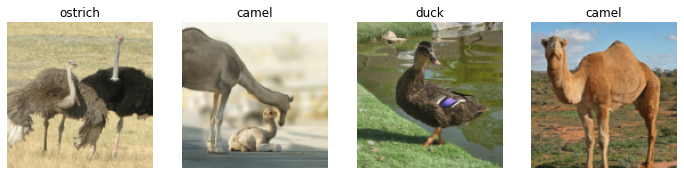

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

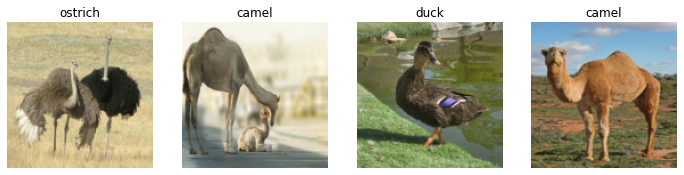

In [16]:
animals = animals.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

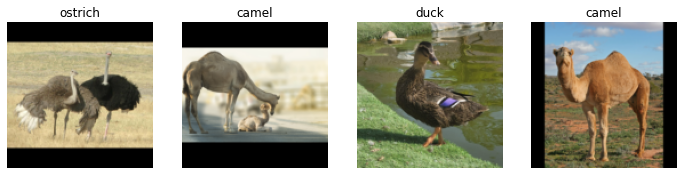

In [17]:
animals = animals.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = animals.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

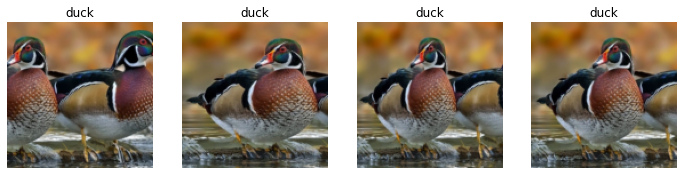

In [18]:
animals = animals.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

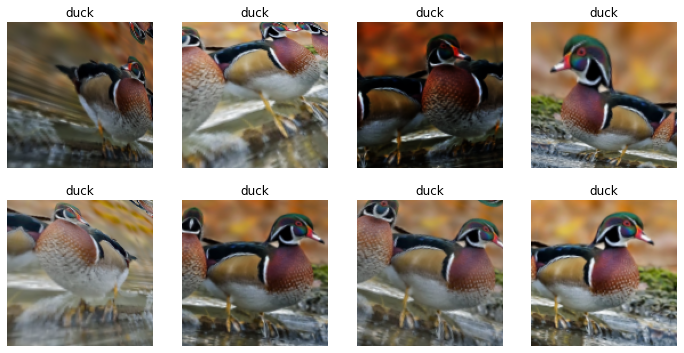

In [19]:
animals = animals.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = animals.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [20]:
animals = animals.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = animals.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.236187,0.453968,0.164706,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.180877,0.075928,0.035294,00:22
1,0.114821,0.018317,0.000000,00:22
2,0.078036,0.010713,0.000000,00:23
3,0.060476,0.010722,0.000000,00:23


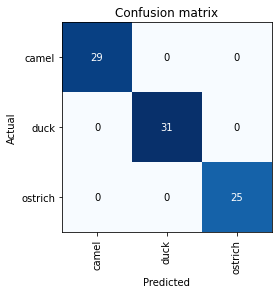

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

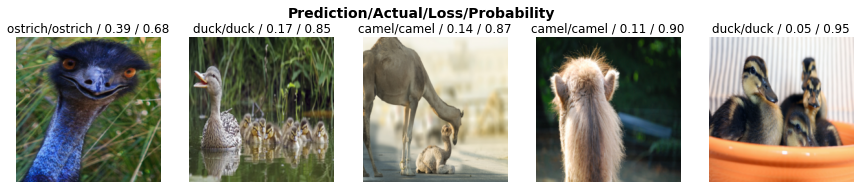

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/camel.jpg')

('camel', TensorBase(0), TensorBase([9.9996e-01, 3.6293e-07, 4.0193e-05]))

In [29]:
learn_inf.dls.vocab

['camel', 'duck', 'ostrich']

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/cat.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your animal!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app